In [1]:
!pip install numpy pandas scikit-learn xgboost lightgbm catboost matplotlib seaborn


  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached lightgbm-4.5.0-py3-none-win_amd64.whl.metadata (17 kB)
  Using cached catboost-1.2.7-cp310-cp310-win_amd64.whl.metadata (1.2 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
  Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl.metadata (61 kB)
  Using cached plotly-5.24.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached tenacity-9.0.0-py3-none-any.whl.metadata (1.2 kB)
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 1.0/124.9 MB 2.6 MB/s eta 0:00:47
    --------------------------------------- 1.6/124.9 MB 2.9 MB/s eta 0:00:43
    --------------------------------------- 2.4/124.9 MB 3.1 MB/s eta 0:00:40
   - -------------------------------------- 3.4/124.9 MB 3.5 MB/s eta 0:00:35
   - -------------------------------------- 4.7/124.9 MB 4.0 MB/s eta 0:00:31
   -- ------------------------------------- 6.3/124.9 MB 4

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, mean_squared_error, 
                           ndcg_score, precision_score, recall_score)
from sklearn.datasets import (make_classification, make_regression, 
                            load_breast_cancer, fetch_california_housing)
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, CatBoostRegressor, CatBoostRanker
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

class GradientBoostingExamples:
    def __init__(self):
        """Initialize the class with common parameters for all models"""
        self.random_state = 42
        self.n_estimators = 100
        
    def prepare_classification_data(self):
        """Prepare data for classification tasks"""
        # Load breast cancer dataset
        data = load_breast_cancer()
        X, y = data.data, data.target
        return train_test_split(X, y, test_size=0.2, random_state=self.random_state)
        
    def prepare_regression_data(self):
        """Prepare data for regression tasks"""
        # Load California housing dataset
        data = fetch_california_housing()
        X, y = data.data, data.target
        return train_test_split(X, y, test_size=0.2, random_state=self.random_state)
    
    def prepare_ranking_data(self):
        """Prepare synthetic data for ranking tasks"""
        # Create synthetic ranking data
        n_samples = 1000
        n_features = 10
        
        X = np.random.rand(n_samples, n_features)
        # Create relevance scores (0 to 4)
        y = np.random.randint(0, 5, size=n_samples)
        # Create groups (queries) - 100 queries with 10 documents each
        groups = np.array([10] * 100)
        
        return train_test_split(X, y, test_size=0.2, random_state=self.random_state), groups

    def classification_benchmark(self):
        """Benchmark different classification algorithms"""
        # Prepare data
        X_train, X_test, y_train, y_test = self.prepare_classification_data()
        
        # Initialize classifiers
        classifiers = {
            'XGBoost': xgb.XGBClassifier(n_estimators=self.n_estimators, random_state=self.random_state),
            'LightGBM': lgb.LGBMClassifier(n_estimators=self.n_estimators, random_state=self.random_state),
            'CatBoost': CatBoostClassifier(n_estimators=self.n_estimators, random_state=self.random_state, verbose=False),
            'RandomForest': RandomForestClassifier(n_estimators=self.n_estimators, random_state=self.random_state),
            'AdaBoost': AdaBoostClassifier(n_estimators=self.n_estimators, random_state=self.random_state),
            'DecisionTree': DecisionTreeClassifier(random_state=self.random_state)
        }
        
        results = {}
        for name, clf in classifiers.items():
            # Train and predict
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            
            # Calculate metrics
            results[name] = {
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred),
                'Recall': recall_score(y_test, y_pred)
            }
            
        return pd.DataFrame(results).T

    def regression_benchmark(self):
        """Benchmark different regression algorithms"""
        # Prepare data
        X_train, X_test, y_train, y_test = self.prepare_regression_data()
        
        # Initialize regressors
        regressors = {
            'XGBoost': xgb.XGBRegressor(n_estimators=self.n_estimators, random_state=self.random_state),
            'LightGBM': lgb.LGBMRegressor(n_estimators=self.n_estimators, random_state=self.random_state),
            'CatBoost': CatBoostRegressor(n_estimators=self.n_estimators, random_state=self.random_state, verbose=False)
        }
        
        results = {}
        for name, reg in regressors.items():
            # Train and predict
            reg.fit(X_train, y_train)
            y_pred = reg.predict(X_test)
            
            # Calculate metrics
            results[name] = {
                'MSE': mean_squared_error(y_test, y_pred),
                'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                'R2': reg.score(X_test, y_test)
            }
            
        return pd.DataFrame(results).T

    def ranking_benchmark(self):
        """Benchmark different ranking algorithms"""
        # Prepare data
        (X_train, X_test, y_train, y_test), groups = self.prepare_ranking_data()
        
        # Split groups for train and test
        n_train = len(X_train)
        train_groups = groups[:n_train//10]
        test_groups = groups[n_train//10:]
        
        # Initialize rankers
        xgb_ranker = xgb.XGBRanker(
            objective='rank:ndcg',
            n_estimators=self.n_estimators,
            random_state=self.random_state
        )
        
        lgb_ranker = lgb.LGBMRanker(
            objective='lambdarank',
            n_estimators=self.n_estimators,
            random_state=self.random_state
        )
        
        cat_ranker = CatBoostRanker(
            n_estimators=self.n_estimators,
            random_state=self.random_state,
            verbose=False
        )
        
        rankers = {
            'XGBoost': xgb_ranker,
            'LightGBM': lgb_ranker,
            'CatBoost': cat_ranker
        }
        
        results = {}
        for name, ranker in rankers.items():
            # Train
            if name == 'XGBoost':
                ranker.fit(X_train, y_train, group=train_groups)
            elif name == 'LightGBM':
                ranker.fit(X_train, y_train, group=train_groups)
            else:  # CatBoost
                ranker.fit(X_train, y_train, group_id=np.repeat(np.arange(len(train_groups)), train_groups))
            
            # Predict
            y_pred = ranker.predict(X_test)
            
            # Calculate NDCG
            results[name] = {
                'NDCG@5': ndcg_score([y_test], [y_pred], k=5),
                'NDCG@10': ndcg_score([y_test], [y_pred], k=10)
            }
            
        return pd.DataFrame(results).T

    def plot_feature_importance(self, model, feature_names, title):
        """Plot feature importance for a given model"""
        plt.figure(figsize=(10, 6))
        
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            importances = model.feature_scores_
            
        indices = np.argsort(importances)[::-1]
        
        plt.title(f"Feature Importances ({title})")
        plt.bar(range(len(importances)), importances[indices])
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_learning_curves(self, model, X_train, X_test, y_train, y_test, title):
        """Plot learning curves for a given model"""
        train_scores = []
        test_scores = []
        estimators = range(10, self.n_estimators + 1, 10)
        
        for n in estimators:
            model.n_estimators = n
            model.fit(X_train, y_train)
            
            train_scores.append(model.score(X_train, y_train))
            test_scores.append(model.score(X_test, y_test))
            
        plt.figure(figsize=(10, 6))
        plt.plot(estimators, train_scores, label='Training Score')
        plt.plot(estimators, test_scores, label='Testing Score')
        plt.xlabel('Number of Estimators')
        plt.ylabel('Score')
        plt.title(f'Learning Curves ({title})')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [3]:
# Cell 1: Initialize the class
gbm_examples = GradientBoostingExamples()

In [4]:
# Cell 2: Run Classification Benchmark
print("Classification Benchmark Results:")
classification_results = gbm_examples.classification_benchmark()
print(classification_results)

Classification Benchmark Results:
[LightGBM] [Info] Number of positive: 286, number of negative: 169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4548
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628571 -> initscore=0.526093
[LightGBM] [Info] Start training from score 0.526093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

d:\Education\Masters\Sem_1\CMPE-255-Data-Mining\Assignments\Python-Colab-CoPilot-Akkio\Assignment-2\backend\.venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              Accuracy  Precision    Recall
XGBoost       0.956140   0.958333  0.971831
LightGBM      0.964912   0.958904  0.985915
CatBoost      0.964912   0.958904  0.985915
RandomForest  0.964912   0.958904  0.985915
AdaBoost      0.973684   0.972222  0.985915
DecisionTree  0.947368   0.957746  0.957746


In [5]:
# Cell 3: Run Regression Benchmark
print("\nRegression Benchmark Results:")
regression_results = gbm_examples.regression_benchmark()
print(regression_results)


Regression Benchmark Results:
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Info] Start training from score 2.071947
               MSE      RMSE        R2
XGBoost   0.222590  0.471794  0.830137
LightGBM  0.214848  0.463517  0.836045
CatBoost  0.217607  0.466484  0.833939


In [6]:
# Cell 4: Run Ranking Benchmark
print("\nRanking Benchmark Results:")
ranking_results = gbm_examples.ranking_benchmark()
print(ranking_results)


Ranking Benchmark Results:
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 10
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

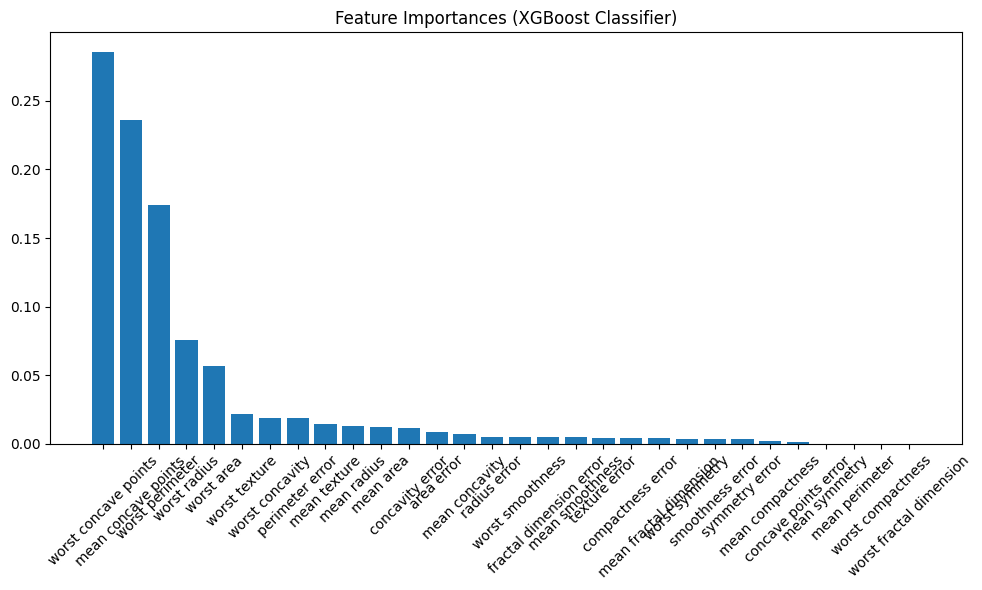

In [7]:
# Cell 5: Visualize Feature Importance for Classification
X_train, X_test, y_train, y_test = gbm_examples.prepare_classification_data()
xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_clf.fit(X_train, y_train)

# Get feature names from breast cancer dataset
feature_names = load_breast_cancer().feature_names
gbm_examples.plot_feature_importance(xgb_clf, feature_names, "XGBoost Classifier")

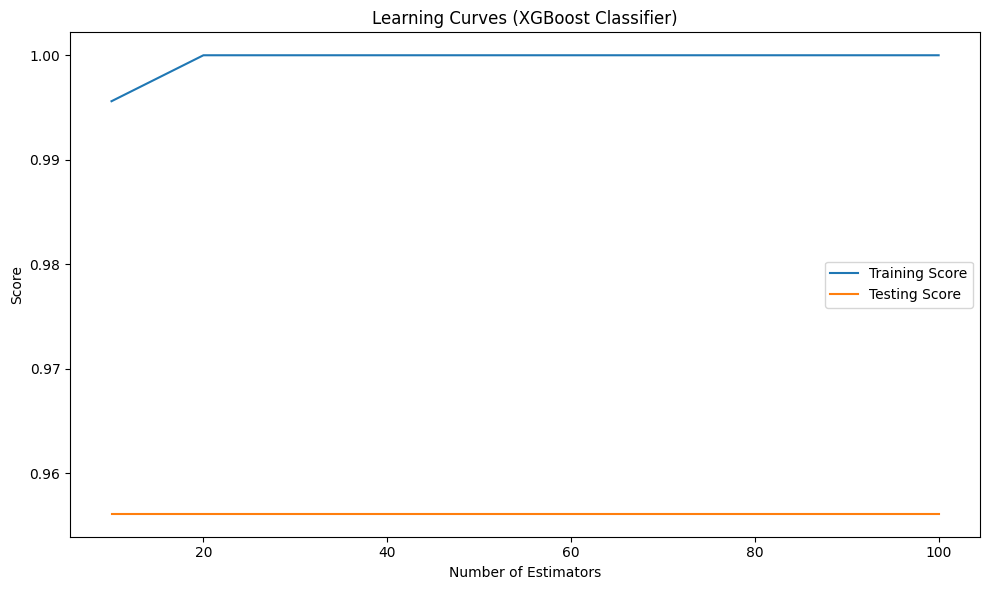

In [8]:
# Cell 6: Plot Learning Curves
gbm_examples.plot_learning_curves(
    xgb.XGBClassifier(random_state=42),
    X_train, X_test, y_train, y_test,
    "XGBoost Classifier"
)